In [1]:
import numpy as np
import networkx as nx
import sympy as sym

import holoviews as hv; hv.extension('bokeh', 'plotly', 'matplotlib', logo=False)
import panel as pn;     pn.extension('plotly', 'katex', 'mathjax')

from alg_graphs.alg_graphs import pr, format_matrix, _plot_pygsp, draw_nxgraph, NxDisplay, nx_from_pygsp, stem_plot
from pygsp import graphs, filters, plotting
from panel.interact import interact

from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from matplotlib.cm import get_cmap

from alg_graphs.alg_graphs import pr, format_matrix, _plot_pygsp, draw_nxgraph, draw_nxmultigraph, NxDisplay, nx_from_pygsp, stem_plot
from pygsp import graphs, filters, plotting
from panel.interact import interact

np.random.seed(146865)

<div style="float:center;width:100%;text-align: center;"><strong style="height:60px;color:darkred;font-size:40px;">Graph Signal Processing</strong></div>

This notebook explores concepts and applications in Graph Signal Processing (GSP),<br>
a framework for analyzing and processing signals defined on graphs. Topics include:

1. Representing graph signals.
2. Graph Differential Operators.
3. Graph Laplacians and their role in spectral decomposition.
4. Spectral analysis of graph signals.
5. Graph filtering, including low-pass and high-pass filters.
6. Applications of GSP: signal smoothing, data interpolation, and spectral analysis.

Interactive visualizations are generated using **Holoviews** and **PyGSP** for enhanced exploration.

# 1. Graph Signals

## 1.1 Definition

<div style="background-color:#F2F5A9;color:black;">

**Definition:** A **graph signal** is a function defined on the vertices of a graph,<br>
$\qquad$ assigning a value (signal) to each vertex.<br>
$\qquad$ For a graph $G = (V, E)$ with $n$ vertices, a graph signal is a vector $\mathbf{x} \in \mathbb{R}^n$.
</div>

**Examples of Graph Signals**
* Consider a set of temperature sensors distributed over a region.<br>
A graph structure is used to encode sensor location and communication links.<br>
How should we analyze temperature variations?
* Consider a social network, where nodes encode individuals with associated data,<br>
and vertices encode friendship.<br>
We may wish to analyze the data, e.g., age and income, as a function of this structure.

The emerging field of signal processing on graphs merges algebraic and spectral
graph theoretic concepts<br>
with computational harmonic analysis
to process such signals on graphs.
* See [**Survey Article**](https://arxiv.org/pdf/1211.0053.pdf)
* See [**youtube lecture (Antonio Ortega)**](https://www.youtube.com/watch?v=296S-zh3WnU)
* See [**GSP Demo**](https://nbviewer.org/github/mdeff/ntds_2017/blob/outputs/demos/08_pygsp.ipynb)
* See [**Talk by Santiago Segarra**](https://www.youtube.com/watch?v=2xMhHh4yWek)

<div style="float:left;width:25%;padding-top:1cm;">
    <strong>Facebook Friendship Circle</strong>
    <img src="Figs/FacebookFriendshipCircle.png" style="margin:0px 0px 0cm 0cm;width:9cm;">
</div>
<div style="float:right;width:56%;">

<br><br>Consider a **graph** $G(V,E)$ with associated data (a **graph signal**)<br>$\qquad$encoded by node color in the Figure on the left.
* **Positive weighted edges** $w_{edge}$ measure similarity.
* **Graph signal** $x = \begin{pmatrix} x_{node_1} \\ x_{node_2} \\ \dots \end{pmatrix}$
* **Neighborhoods** (e.g., nodes within $k$ hops)
This is a flexible model for many problems.
</div>

## 1.2 Example: Visualizing Graph Signals

Below, we create a simple graph and assign random signal values to its vertices. 
The node colors represent the signal values.

We will use both holoviews and pypsp to plot the graphs.

In [2]:
# Create a random graph with 10 nodes and a connection probability of 0.3
def graph_signal_example():
    n = 10
    p = 0.3
    G = nx.erdos_renyi_graph(n, p, seed=42)
    signal = np.random.rand(n)  # Random signal values for nodes

    # Add the signal as a node attribute
    for i, val in enumerate(signal):
        G.nodes[i]["signal"] = val

    def use_hv():
        # Create a Holoviews graph
        hv_graph = hv.Graph.from_networkx(G, nx.spring_layout)

        # Extract node positions for labeling
        layout = hv_graph.nodes.data  # Node positions and attributes
        label_data = {"x": layout["x"], "y": layout["y"], "text": layout["index"]}  # Add index as text
        labels = hv.Labels(label_data, ["x", "y"], "text")  # Define dimensions

        graph_with_labels = hv_graph.opts(
                                height=345, width=450,
                                node_size=20, node_color="signal", cmap="blues",
                                colorbar=True, colorbar_position = 'bottom',
                                title="Random Graph with Node Signals" ) * \
                            labels.opts(
                                text_font_size="10pt", text_align="center", text_baseline="middle",
                                text_color="white", #border_line_color="black", border_line_width=1.5
                            )
        return graph_with_labels
    def use_pygsp():
        g = graphs.Graph(nx.adjacency_matrix(G))  # Note: can add edge weights
        g.set_coordinates('spring')

        plot_opts = { 'arrows':False, 'node_size': 100*(signal-min(signal)+3), 'edge_width': 3*hv.dim('weight') }
        h,c1,c2   = _plot_pygsp(g, node_cmap= 'cwr', node_color = signal, edge_cmap='kb', **plot_opts)
        return pn.Column( h.opts(height=250, title = "Node Size (and edge width) as well as Colors Show Values"),
           pn.Row( c1.opts(width=260), c2.opts(width=260)),
           width = 500 )

    return pn.Row( use_hv(), use_pygsp())
pn.Row(graph_signal_example())

Row
    [0] Row
        [0] HoloViews(Overlay, height=345, sizing_mode='fixed', width=450)
        [1] Column(width=500)
            [0] HoloViews(Overlay, height=250, sizing_mode='fixed', width=600)
            [1] Row
                [0] HoloViews(HeatMap, sizing_mode='fixed', width=260)
                [1] HoloViews(HeatMap, sizing_mode='fixed', width=260)

# 2. Differential Graph Operators

## 2.1 Definitions: Graph Derivative, Gradient and Divergence

<div style="background-color:#F2F5A9;color:black;">

**Definitions:** Let $G(V,E,w)$ be a finite weighted graph, and let $f : V \rightarrow \mathbb{R}$ be a vertex function
* The **weighted graph derivative** of $f$ along a directed edge $(u,v) \in E$ is $\;\;\partial_v f(u) = \sqrt{w_{u v}} \left(\ f(v)-f(u)\ \right)$

* The **weighted gradient** is the vector $\;\;\nabla f = \left( \partial_v f(u) \right)$ for all edges $(u,v) \in E$

* The $\mathbf{\mathscr{l}_p}$ **norm** $\;\Vert \nabla f \Vert_p = \left( \sum_{(u,v) \in E}{\; w_{u v}^{\frac{p}{2}} \ ( f(v) - f(u) )^p } \right)^\frac{1}{p},\;\;$ so that $\;\;\Vert \nabla f \Vert_2 = \left( \sum_{(u,v) \in E}{}w_{u v}( f(v) - f(u) )^2\right)^\frac{1}{2}.$

* The **weighted divergence** at a given node $u$ is $div_u( \nabla f ) = \sum_{v \in \mathscr{N}_u}{ \sqrt{w_{u v}}\ \partial_v f(u) }$<br><br>
$\qquad$ substituting for the partial derivatives, we obtain $div_u( \nabla f ) =  \sum_{v \in \mathscr{N}_u} w_{u v} ( x_v - x_u ) = (L f)_u$.<br>
$\qquad$ The divergence on a graph measures the net outflow of an edge function in each vertex of the graph.
</div>

**Remarks:**
* $\;\Vert \nabla_u f \Vert_p$ provides a measure of signal variability of $f(u)$ around vertex $u$.<br>$\qquad$
The **graph signal is said to be smooth** in the neighborhood of $u$ when this quantity is small.
* Thus $\Vert \nabla_u f \Vert_p > \Vert \nabla_v f \Vert_p$ indicates that the signal variation at node $u$ is higher than the variation at node $v$.
* For a constant signal at node $u$, $\nabla_u f = 0$.

<div style="background-color:#F2F5A9;color:black;">

**Definition:** Extend the signal variation of the whole graph by means of the $p$-Dirichlet form (using the $\mathscr{l}_2$ norm)<br>
$\qquad S_p(f) = \frac{1}{p} \sum_{v \in V} \Vert \nabla_v f \Vert_2^\frac{1}{p} \;\; = \frac{1}{p} \sum_{v \in V} \left( \sum_{u \in \mathscr{N}_v}{w_{v u}( f(v)-f(u))^2}\right)^\frac{1}{p}$

Special Cases:
* the **signal total variation:** $\qquad\ S_1(f) =  \sum_{v \in V} \sum_{u \in \mathscr{N}_v}{w_{v u}( f(v)-f(u))^2}$
* the **Laplacian quadratic form:** $\;\;S_2(f)   = \sum_{(u,v) \in \mathscr{E}_v}{w_{v u}( f(v)-f(u))^2}$<br>
Note $S_2(f) = f^t L f$, where $L$ is the graph Laplacian
</div>

In [8]:
# using pyGSP graphs G ; note that 'f' is the signal
def adjacent_nodes(G, u):                    return list(G.W[u].nonzero()[1])
def gradient_vector(G, f, u):                return { v: np.sqrt(G.W[u,v])*(f[v]-f[u]) for v in adjacent_nodes(G, u)}
def gradient_vector_norm(G,f,u,p=2):         return (np.linalg.norm([ np.sqrt(G.W[u,v])*(f[v]-f[u]) for v in adjacent_nodes(G, u)], p))
def divergence(G, f, u):                     return (G.L @ f)[u]
def signal_variation_at_node( G, u, f, p=2): return (np.linalg.norm([ np.sqrt(G.W[u,v])*(f[v]-f[u]) for v in adjacent_nodes(G, u)], 2)**(1/p) / p)
def signal_variation(G,f,p=2):               return np.sum([ signal_variation_at_node(G,u,f,2)**(1/p) for u in range(G.N)])/p

## 2.2. Example of Differential Graph Operators

In [4]:
# Construct the Graph adding weight to the edges and then the signal
def mk_graph(N,p):
    def rand_adj(n,p):
        A        = np.zeros((n,n))
        for i in range(n):
            for j in range(i):
                if np.random.uniform() < p:
                    A[i,j] = 1.+np.random.rand()
                    A[j,i] = A[i,j]
        return A
    import pygsp
    g = pygsp.graphs.Graph(rand_adj(N,p))
    g.set_coordinates('spring')
    return g

def graph_signal_with_edge_weights_example():
    G = mk_graph(8, (np.log(8)+2)/8)
    f = 10.*np.random.uniform(-1, 1, size=G.N)
    plot_opts = { 'arrows':False, 'node_size': 80*(f-min(f)+3), 'edge_width': 3*hv.dim('weight') }
    h,c1,c2   = _plot_pygsp(G, node_cmap= 'cwr', node_color = f, edge_cmap='kb', **plot_opts)
    vis = pn.Row(
        pn.Column( h.opts(height=250, title = "Node size and edge width as well as colors show values"),
                   pn.Row( c1.opts(width=260), c2.opts(width=260)),
                   width = 500 ),
        pn.Spacer(width=120),
        pn.Column(pn.Spacer(height=20),
                pn.pane.Markdown( f'### Adjacency Matrix:  ( {G.N} nodes and {G.Ne} edges)'),
                pn.pane.LaTeX( r'$\qquad'+format_matrix(np.round( G.W.toarray(),2))+'$' )))
    return G, f, vis
pygsp_G, signal, vis = graph_signal_with_edge_weights_example()
vis

Row
    [0] Column(width=500)
        [0] HoloViews(Overlay, height=250, sizing_mode='fixed', width=600)
        [1] Row
            [0] HoloViews(HeatMap, sizing_mode='fixed', width=260)
            [1] HoloViews(HeatMap, sizing_mode='fixed', width=260)
    [1] Spacer(width=120)
    [2] Column
        [0] Spacer(height=20)
        [1] Markdown(str)
        [2] LaTeX(str, renderer='katex')

In [5]:
def mk_summary(G, f, u):
    adj = [int(i) for i in adjacent_nodes(G,u)]
    summary = f"""<br><strong> nodes {adj} are adjacent to node {u}</strong><br>
    The weighted derivatives at node {u} are:<br>
    """
    d_u =  gradient_vector(G, f, u)
    for v in d_u.keys():
        summary += f"&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; {u}->{v} :  {round( d_u[v], 2)}<br>"
    summary += f"<br>The gradient vector 2-norm at node {u}: {np.round(gradient_vector_norm(G,f,u),2)}<br>"
    summary += f"<br>The divergence at a node is the sum of the weighted derivatives at the node:<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp div(df)({u})): {np.round(divergence(G,f,u) ,2)}"
    return summary

pvals = np.arange(1, 20.8, 0.5)
pn.Row(hv.Curve(( pvals, [signal_variation(pygsp_G,signal,p) for p in pvals] )).opts(title="Signal Variation S_p(f) versus p", tools=['hover'],
                                                                          width=400, show_grid=True, xticks=[2,5,10,15,20]),
       pn.Spacer(width=50), pn.Column( pn.pane.HTML( mk_summary(pygsp_G, signal, 1) ),
                                       pn.pane.LaTeX( r"The <strong>gradient</strong> is the vector of weighted derivaties $\partial_v f(u)$<br>$\qquad$for ever pair of edges $(u,v)$"))
      )

Row
    [0] HoloViews(Curve, height=300, sizing_mode='fixed', width=400)
    [1] Spacer(width=50)
    [2] Column
        [0] HTML(str)
        [1] LaTeX(str, renderer='katex')

In [10]:
# Compute the weighted derivate for each of the edges in the graph, compute the divergence at each node
pygsp_G.compute_differential_operator()                # compute D such that L = D.T D
grad    = pygsp_G.grad(signal)
#print( "Gradient:", np.round(pygsp_G.D @ signal,2))   # compute the gradient explicitely
#display = NxDisplay( nx_from_pygsp(pygsp_G), signal, grad)
#pn.Column( #display.plot_layout(title="Signal Gradient at each Edge", height=300),

print( "Divergence:", np.round(pygsp_G.div(pygsp_G.grad(signal)), 2)) # compute it using utility function
pn.Row( stem_plot( pygsp_G.div(pygsp_G.grad(signal)), kdims=["node","divergence"]).opts( title="Divergence of Signal versus Node", xlabel='vertex', width = 400),
        stem_plot(grad, kdims=["edge","gradient"]).opts( title="Gradient of Signal versus Edge", xlabel='edge', width = 400)  # compute it using utility function
)

Divergence: [-13.37  -3.9  -16.76 -17.26   9.4   -2.51  71.74 -27.34]


Row
    [0] HoloViews(Overlay, height=300, sizing_mode='fixed', width=400)
    [1] HoloViews(Overlay, height=300, sizing_mode='fixed', width=400)

# 3. Graph Laplacians

We first encountered the Laplacian in [02_OtherMatrixRepresentaions.ipynb](02_OtherMatrixRepresentaions.ipynb). This matrix encodes the graph's structure and is useful for spectral decomposition. Remember

<div style="background-color:#F2F5A9;color:black;">

**Definition:** Given a weighted graph $G= (V, E, W)$ the **Laplacian** $L(G)$ is the symmetric matrix $L$ defined<br>
$\qquad
L_{i j} = \left\{ \begin{align}
& deg(v_i), \qquad & \text{ if }\; i=j \\
& -1, \qquad & \text{ if }\; i \ne j \;\text{ and vertex }\; v_i \; \text{ is adjacent to vertex } \; v_j \\
& \;\;0,        & \text{ otherwise}
\end{align}\right.
$<br>

$\qquad$ that arises in the quadratic form $\;\; x^t\ W L\ x = \sum_{(a,b) \in E}{\ w_{a b}\ \left( x_a - x_b \right)^2}.$

$\qquad$ The weights are taken to be non-negative $W \ge 0$, and $x$ is a signal defined at each node of $G$.
</div>

Some basic facts about $W L$:
* Since the weights $w_{a b} \ge 0$, the Laplacian is positive semidefinite
* $x^t\ W L\ x =  \sum_{(a,b) \in E}{w_{a b} x_a^2}
                    - 2 \sum_{(a,b) \in E}{w_{a b} x_a x_b } + \sum_{(a,b) \in E}{w_{a b} x_b^2}$<br>
  where the $x_a^2$ and $x_b^2$ terms correspond to the in and out degrees of particular vertices,
    * For an undirected graph, $L = D - A$, where $D$ is the degree matrix and $A$ is the adjacency matrix of $G$.
    * For a directed graph, either the in-degree or the out degree might be used.
* The Laplacian matrix $L$ is **symmetrix**
* The row and column sums of $L$ are zero.<br>
Thus $L$ has a zero eigenvalue with an eigenvector $\mathbf{1}$.

### Extension: The Weighted Laplacian

The **weighted Laplacian matrix** is an extension of the standard graph Laplacian that incorporates edge weights.

<div style="background-color:#F2F5A9;color:black;">

**Definition:**<br>
$\qquad$ For a weighted graph $G$ with $n$ vertices, the weighted Laplacian $L$ is an $n \times n$ matrix defined as<br>
$\qquad\qquad$ $L = D - W,\;\;$ where
* $W$ is the weighted adjacency matrix of the graph
* $D$ is the weighted degree matrix: a diagonal matrix where $D_{i i}$ is the sum of weights of edges incident to vertex $i$.
</div>

**Properties**
* **Symmetric:** The weighted Laplacian is symmetric for undirected weighted graphs.
* **Positive semi-definite:** All eigenvalues are non-negative.
    * The smallest eigenvalue is always 0, and its multiplicity equals the number of connected components in the graph.
    * The eigenvectors corresponding to the eigenvalue 0 are the constant vectors.

Repeating the examples from [02_OtherMatrixRepresentaions.ipynb](02_OtherMatrixRepresentaions.ipynb), we have

Column
    [0] Column
        [0] Markdown(str)
        [1] Row
            [0] Matplotlib(Figure, dpi=96, height=200)
            [1] Column
                [0] Spacer(height=50)
                [1] LaTeX(str, renderer='katex')
            [2] Column
                [0] Spacer(height=50)
                [1] LaTeX(str, renderer='katex')
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] Matplotlib(Figure, dpi=96, height=200)
            [1] Column
                [0] Spacer(height=50)
                [1] LaTeX(str, renderer='katex')
            [2] Column
                [0] Spacer(height=50)
                [1] LaTeX(str, renderer='katex')
            [3] Column
                [0] Spacer(height=50)
                [1] LaTeX(str, renderer='katex')
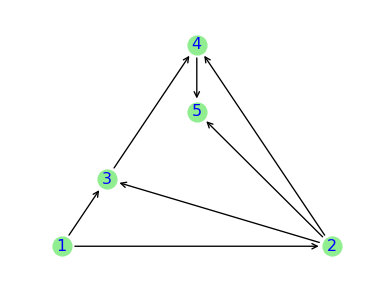
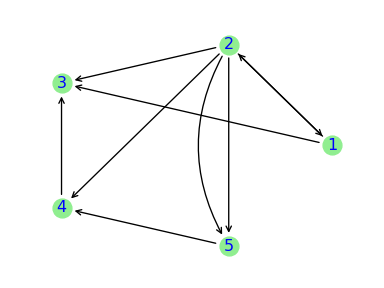

In [11]:
uG = nx.MultiGraph()
uG.add_nodes_from(range(1,6))
uG.add_edges_from([(2,1), (1,3), (2,3), (2,4), (2,5), (5,4), (4,3)])
uL = nx.laplacian_matrix(uG).todense()
uA    = nx.adjacency_matrix(uG).todense()

dG = nx.MultiDiGraph()
dG.add_nodes_from(range(1,6))
dG.add_edges_from([(1,2), (2,1), (1,3), (2,3), (2,4), (2,5), (5,4), (4,3),(2,5)])

inD  = np.diag([ d for i,d in dG.in_degree()])
outD = np.diag([ d for i,d in dG.out_degree()])
dA    = nx.adjacency_matrix(dG).todense()

pn.Column(
pn.Column( "## Using Full degree",
pn.Row( pn.pane.Matplotlib( draw_nxmultigraph(uG, nx.planar_layout, arrows='->'), dpi=96,  height=200),
        pn.Column(pn.Spacer(height=50), pn.pane.LaTeX( 'Adjacency Matrix $A = '+ format_matrix(uA)+'$' )),
        pn.Column(pn.Spacer(height=50), pn.pane.LaTeX( 'Laplacian Matrix $L = '+ format_matrix(uL)+'$' )),
      )),
pn.Column( "## Using In-degree and/or Out-degree",
pn.Row( pn.pane.Matplotlib( draw_nxmultigraph(dG, nx.circular_layout, arrows='->'), dpi=96,  height=200),
        pn.Column(pn.Spacer(height=50), pn.pane.LaTeX( 'Adjacency Matrix $A = '+ format_matrix(dA)+'$' )),
        pn.Column(pn.Spacer(height=50), pn.pane.LaTeX( '$L_{in} = ' +format_matrix(inD-dA)+'$' )),
        pn.Column(pn.Spacer(height=50), pn.pane.LaTeX( '$L_{out} = '+format_matrix(outD-dA)+'$' ))
      ))
)

Graph Signal Processing may use other matrices, such as

<div style="background-color:#F2F5A9;color:black;">

**Definition:**  Given a weighted graph $G= (V, E, W)$ the **normalized Laplacian** is defined as<br>
$\qquad L_{norm} = I - D^{-1/2} A D^{-1/2}$
</div>

As a final reminder, the Laplacian is related to the incidence matrix by
<div style="background-color:#F2F5A9;color:black;">

**Theorem:** Let $G$ be a graph with oriented incidence matrix $Q$ and Laplacian $L$, then<br>
$\qquad L = Q Q^t$.
</div>

### Example: Compute Laplacians

In [12]:
# Compute adjacency matrix and Laplacians
uA    = nx.adjacency_matrix(uG).todense()
uD = np.diag(uA.sum(axis=1))
uL = uD - uA

# Compute normalized Laplacian
uD_inv_sqrt = np.diag(1 / np.sqrt(uD.diagonal()))
uL_normalized = np.eye(uA.shape[0]) - uD_inv_sqrt @ uA @ uD_inv_sqrt

# Display Laplacians
pn.Row(
pn.pane.LaTeX( '$L = '+format_matrix(uL)+'$' ),
pn.pane.LaTeX( '$L_{normalized} = '+format_matrix(np.round(uL_normalized,2))+'$' ),
)

Row
    [0] LaTeX(str, renderer='katex')
    [1] LaTeX(str, renderer='katex')

# 4. Spectral Decomposition

Since the Laplacian is positive semidefinite, it has an orthogonal eigendcomposition: $L = U \Lambda U^t,$<br>
$\qquad$ where $U$ is an orthogonal matrix consisting of columns of real eigenvectors,<br>
$\qquad$ and $\Lambda$ is a real diagonal matrix with the eigenvalues on the diagonal.

We **choose to order the eigenvalues** (and hence the eigenvectors) in increasing order:<br>
$\qquad \mathbf{0=\lambda_1 \le \lambda_2 \dots \le \lambda_N}$.

Small eigenvalues correspond to smooth variations in graph signals, while large eigenvalues capture rapid changes.

The spectrum thus provides insights into the structure of the graph and the behavior of graph signals.

## 4.1. Example: Compute and Visualize the Laplacian Spectrum

In [13]:
G = mk_graph(5, (np.log(5)+2)/5)
G.compute_differential_operator()

plot_opts = { 'arrows':False, 'node_size': 300, 'edge_width': 3*hv.dim('weight') }
h,c1,c2   = _plot_pygsp(G, node_cmap= 'cwr', node_color = "lightblue", edge_cmap='kb', **plot_opts)
pn.Row(
pn.Column( h.opts(height=250, title = "Example Weighted Graph"),
           pn.Row( c1.opts(width=260), c2.opts(width=260)),
           width = 500 ),
pn.Spacer(width=120),
pn.Column(pn.Spacer(height=20),
        pn.pane.Markdown( f'### Adjacency Matrix:  ( {G.N} nodes and {G.Ne} edges)'),
        pn.pane.LaTeX( r'$\qquad'+format_matrix(np.round( G.W.toarray(),2))+'$' ),
        pn.pane.Markdown( f'### Incidence Matrix:'),
        pn.pane.LaTeX( r'$\qquad'+format_matrix(np.round( G.D.T.toarray(),2))+'$' ),
))

Row
    [0] Column(width=500)
        [0] HoloViews(Overlay, height=250, sizing_mode='fixed', width=600)
        [1] Row
            [0] HoloViews(Curve, height=1, sizing_mode='fixed', width=260)
            [1] HoloViews(HeatMap, sizing_mode='fixed', width=260)
    [1] Spacer(width=120)
    [2] Column
        [0] Spacer(height=20)
        [1] Markdown(str)
        [2] LaTeX(str, renderer='katex')
        [3] Markdown(str)
        [4] LaTeX(str, renderer='katex')

In [15]:
G.compute_fourier_basis()
print( f"Eigenvalues of L: {np.round(G.e,2)}")

pn.Row( pn.Column(pn.Spacer(height=20), pn.pane.Markdown( '<strong style="font_size:20px;height:25px;color:blue;">The Laplacian for the Example above is given by</strong>'),
                  pn.pane.LaTeX( r'$\qquad'+format_matrix(np.round( G.L.toarray(),2))+'$' )
                 ), pn.Spacer(width=20),
        hv.Scatter( G.e, "index", "Frequency" ).opts( size=5, width=500, show_grid=True, tools=['hover'], title="Frequencies (i.e., eigenvalues of L)"))

Eigenvalues of L: [0.   1.17 2.21 5.2  7.18]


Row
    [0] Column
        [0] Spacer(height=20)
        [1] Markdown(str)
        [2] LaTeX(str, renderer='katex')
    [1] Spacer(width=20)
    [2] HoloViews(Scatter, height=300, sizing_mode='fixed', width=500)

## 4.2 Eigenvector Zero Crossings

In [16]:
def number_of_zero_crossings(v): return ((v[:-1] * v[1:]) < 0).sum()

#define the display objects and the update function
display   = NxDisplay( nx_from_pygsp(G), G.U[:,3], node_size=600, edge_cmap="None", edge_color="black" )
vdisplay  = pn.pane.HoloViews()

def update_i(i):
    display.title = f"Fourier Vector {i}"
    display.set_node_signal( G.U[:,i], update_plot=True)
    vdisplay.object = stem_plot( G.U[:,i], kdims=["index", f"U[{i}]"]).opts(width=500, title=f"Fourier Vector {i}, Frequency {np.round(G.e[i],3)}, {number_of_zero_crossings(G.U[:,i])} zero crossings")

# lay the objects out using interact()
pn.Column(
    interact( update_i, i=(0,G.U.shape[0]-1)),
    pn.Column(display.plot_layout(title="Fourier Vector", height=250),  vdisplay ),
)

Column
    [0] Column
        [0] Column
            [0] IntSlider(end=4, name='i', value=2)
        [1] Row
            [0] Str(None, name='interactive02607')
    [1] Column
        [0] Column(width=800)
            [0] HoloViews(Overlay, height=250, sizing_mode='fixed', width=800)
            [1] Row
                [0] HoloViews(HeatMap, sizing_mode='fixed', width=260)
                [1] HoloViews(Curve, height=1, sizing_mode='fixed', width=260)
        [1] HoloViews(Overlay, height=300, sizing_mode='fixed', width=500)

**Remark:** for large graphs,  the number of zero crossings tend to increase with the index, starting with 0 for eigenvalue 0.<br>

In [33]:
bigG = mk_graph(100,.4)
bigG.compute_differential_operator()
bigG.compute_fourier_basis()

pn.Row(stem_plot([int(number_of_zero_crossings(bigG.U[:,i])) for i in range(bigG.U.shape[1])]).opts(title="Number of zero crossings", width=400))

Row
    [0] HoloViews(Overlay, height=300, sizing_mode='fixed', width=400)

## 4.3. Fourier Decomposition (i.e., Orthogonal Decomposistion)

<div style="background-color:#F2F5A9;color:black;">

**Definition:** Let $L = U \Sigma U^t$ be an orthonormal decomposition of the Laplacian matrix $L$.<br>
$\qquad$ The Fourier Transform of a signal $x$ is given by $\mathscr{F}(x) = U^t x$.

$\qquad$ The inverse Fourier transform is given by $\mathscr{F}^{-1}(x) = U x$.
</div>

Why call this a Fourier transform? Consider the special case of a ring:

In [88]:
graph = graphs.Ring(N=50)
plot_opts = { 'arrows':False, 'node_size': 300, 'edge_width': np.ones(graph.Ne) }
h,c1,c2   = _plot_pygsp(graph, node_cmap= 'cwr', node_color = "lightgreen", edge_cmap='kb', **plot_opts)
pn.Row(
pn.Column( h.opts(height=300, title = "Node size and edge width as well as colors show values"), width = 500 ),
pn.Spacer(width=120),
pn.Column(pn.Spacer(height=20),
        pn.pane.Markdown( f'### Adjacency 10x10 SubMatrix:  ( {graph.N} nodes and {G.Ne} edges)'),
        pn.pane.LaTeX( r'$\qquad'+format_matrix(np.round( graph.W.toarray().astype(int)[0:10,0:10],2))+'$' )))

Row
    [0] Column(width=500)
        [0] HoloViews(Overlay, height=300, sizing_mode='fixed', width=600)
    [1] Spacer(width=120)
    [2] Column
        [0] Spacer(height=20)
        [1] Markdown(str)
        [2] LaTeX(str, renderer='katex')

In [89]:
graph.compute_fourier_basis()
interact( lambda i: stem_plot( graph.U[:,i]).opts(width=800, title=f"Fourier Basis Vector {i+1}, Frequency {np.round(graph.e[i],3)}"), i=(0,graph.U.shape[0]-1))

Column(sizing_mode='fixed')
    [0] Column
        [0] IntSlider(end=49, name='i', value=24)
    [1] Row(sizing_mode='fixed')
        [0] HoloViews(Overlay, height=300, name='interactive23861', sizing_mode='fixed', width=800)

## 4.4 Transforms Induced by Other Matrices

Instead of the **Laplacian** $L = D - A$, we can use other matrices such as
* the **normalized Laplacian** $\tilde{L} = D^{-\frac{1}{2}} L D^{-\frac{1}{2}} = I - D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$
* the **adjacency matrix**
* the **normalized adjacency matrix**.

If the matrix is deficient (which is possible when it is not symmetric),<br>$\qquad$ the eigendecomposition may have to be replaced with either the Schur decomposition or the Jordan decomposition.<br>
$\qquad$ Note that the SymPy library provides the function $P, J = $*A.jordan_form*$()$ for a given matrix $A$.

Row
    [0] Matplotlib(Figure, dpi=96, width=400)
    [1] Column
        [0] Spacer(height=30)
        [1] LaTeX(str, renderer='katex')
        [2] LaTeX(str, renderer='katex')
        [3] LaTeX(str, renderer='katex')
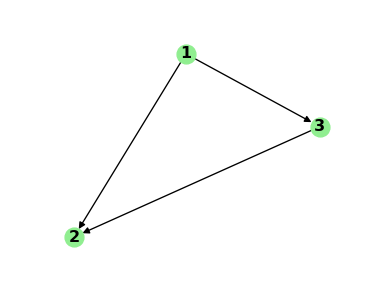

In [91]:
G = nx.DiGraph()
G.add_edges_from( [(1,2), (1,3), (3,2)])
Ag  = sym.Matrix( nx.adjacency_matrix(G).todense() )
P,J = Ag.jordan_form()

fig = draw_nxgraph( G, layout=nx.spring_layout )
pn.Row( pn.pane.Matplotlib( fig, dpi=96,  width=400),
       pn.Column( pn.Spacer(height = 30),
                  pn.pane.LaTeX("Adjacency Matrix: " +  r'$\qquad A = '+format_matrix(Ag)+'$' ),
                  pn.pane.LaTeX("Jordan Vectors:   " +  r'$\quad\qquad P = '+format_matrix(P)+'$' ),
                  pn.pane.LaTeX("Jordan Block:   " +  r'$\;\;\quad\qquad J = '+format_matrix(J)+'$' ),
))

In the next notebook [05_ShiftMatrixForCircularGraphs.ipynb](05_ShiftMatrixForCircularGraphs.ipynb) we will further analyze the eigendecompositon of matrices for Circular Graphs.